## Import librairies

In [3]:
%matplotlib inline

from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from yellowbrick.cluster import InterclusterDistance, SilhouetteVisualizer, KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from itertools import product

pd.set_option("display.max_columns", None)

## Load the dataset

We will start by loading the digits dataset. This dataset contains handwritten digits from 0 to 9. In the context of clustering, one would like to group images such that the handwritten digits on the image are the same.

In [4]:
digits = load_digits()  # Dimensionality: 64 features

X, labels = digits.data, digits.target
images = digits.images

# column name for 64
column_names = [f"X{i}" for i in range(64)]

data = pd.DataFrame(X, columns=column_names).assign(label=labels)

(n_samples, n_features), n_digits = X.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [5]:
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


## EDA

C:\Users\user\AppData\Local\Temp\ipykernel_20324\3374211802.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette='tab10')


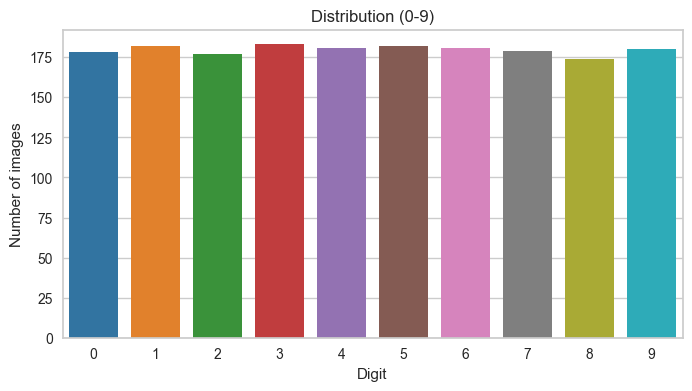

In [6]:
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=data, palette='tab10')

plt.title("Distribution (0-9)")
plt.xlabel("Digit")
plt.ylabel("Number of images")
plt.show()

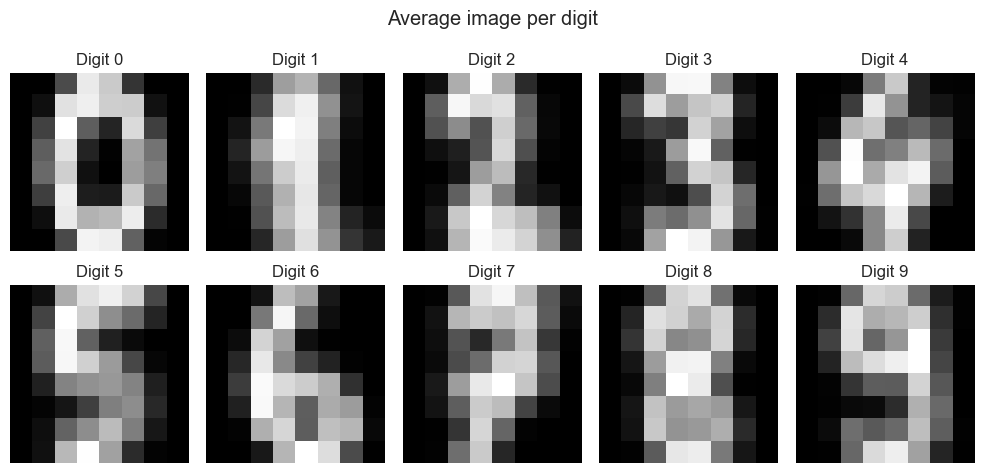

In [7]:
# mean by digit
mean_images = np.zeros((10, 64))  # 64 pixels
for i in range(10):
    mean_images[i] = data.loc[data.label == i, column_names].mean(axis=0)


fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(mean_images[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Digit {i}")
    ax.axis('off')
plt.suptitle("Average image per digit")
plt.tight_layout()
plt.show()

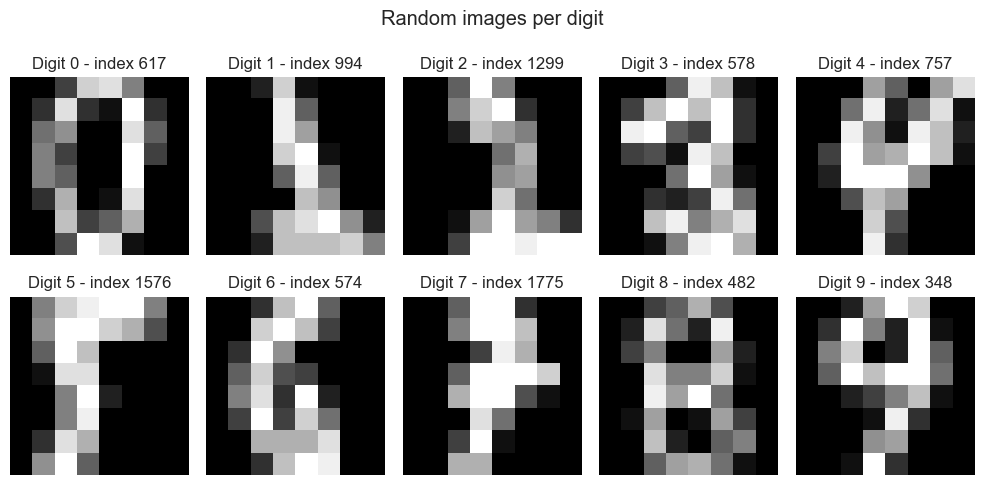

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, hspace=0.5)

for i, label in enumerate(np.unique(labels)):
    ax = axs[i // 5, i % 5]
    # Random choice by digit
    idx = np.random.choice(np.where(labels == label)[0])
    ax.imshow(images[idx], cmap='gray')
    ax.set_title(f"Digit {label} - index {idx}")
    ax.axis('off')

plt.suptitle("Random images per digit")
plt.tight_layout()
plt.show();

## Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to compare different initialization methods for KMeans. Our benchmark will:

create a pipeline which will scale the data using a StandardScaler;

train and time the pipeline fitting;

measure the performance of the clustering obtained via different metrics.


In [9]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]


    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

### Run benchmark

In [10]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=X, labels=labels)

pca = PCA(n_components=n_digits).fit(X)# On peut mettre 85
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=X, labels=labels)

#pca = PCA(n_components=0.99).fit(X)# On peut mettre 85
#kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=1)
#bench_k_means(kmeans=kmeans, name="PCA-based", data=pca.transform(X), labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	2.744s	4647	0.739	0.747	0.743	0.669	0.190
random   	0.103s	4648	0.735	0.742	0.738	0.667	0.182
PCA-based	0.083s	4647	0.744	0.753	0.749	0.673	0.176
__________________________________________________________________________________


## Optimal number of clusters

In [11]:
scaler = MinMaxScaler()  # StandardScaler()
X_scaled = scaler.fit_transform(X)

### Elbow method

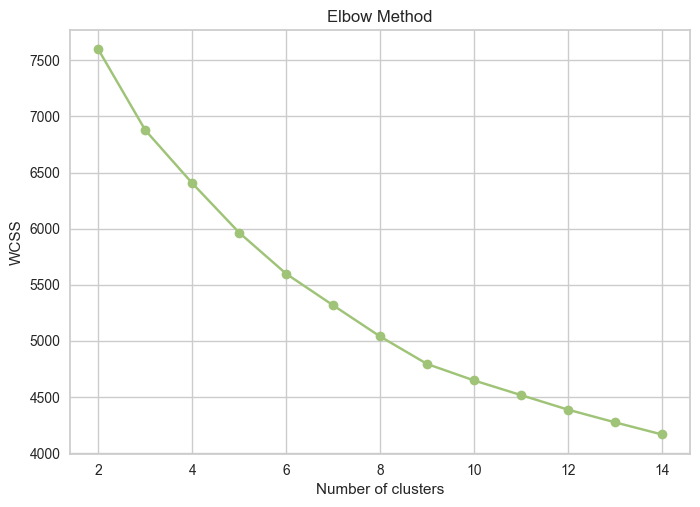

In [12]:
wcss = []  # Within-Cluster Sum of Squares

k_grid = range(2, 15)
for i in k_grid:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(k_grid, wcss, 'go-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Yellow brick lib

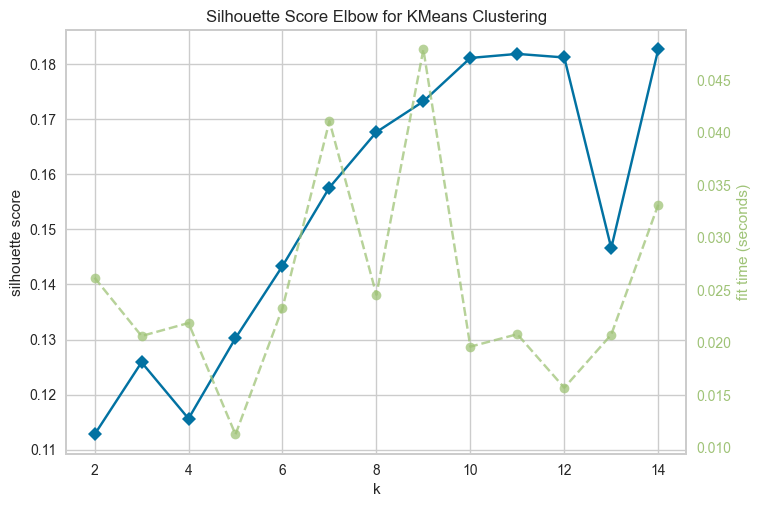

In [13]:
# Instantiate the clustering model and visualizer

# - **distortion**: mean sum of squared distances to centers
# - **silhouette**: mean ratio of intra-cluster and nearest-cluster distance
# - **calinski_harabasz**: ratio of within to between cluster dispersion


visualizer = KElbowVisualizer(KMeans(),
                              metric='silhouette',  # possible values: calinski_harabasz, distortion, silhouette
                              distance_metric="euclidean", # options allowed by sklearn's metrics.pairwise.pairwise_distances
                              k=k_grid,
                              timings=True,
                              locate_elbow=False, # True or False
                             )

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show();       # Finalize and render the figure

## Visualize the results on PCA-reduced data


### Profiling: cluster persona

In [14]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

kmean_labels = kmeans.labels_

In [15]:
data["cluster"] = kmean_labels
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label,cluster
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0,2
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1,0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2,9
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3,7
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4,4


In [16]:
# Mapping cluster => label
contingency_table = pd.crosstab(data["cluster"], data["label"])
contingency_table

label,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,0,89,1,0,10,1,0,23,4,0
1,3,5,4,26,0,43,0,0,3,123
2,157,0,0,0,0,6,7,0,0,0
3,0,0,120,37,0,4,0,2,4,5
4,1,2,0,0,148,2,29,1,1,0
5,15,0,0,0,16,5,143,0,0,1
6,2,25,31,11,0,42,0,1,69,19
7,0,0,3,97,0,1,0,0,0,13
8,0,9,5,12,3,23,0,115,24,9


In [17]:
major_digit = contingency_table.idxmax(axis=1)
print(major_digit)

cluster
0    1
1    9
2    0
3    2
4    4
5    6
6    8
7    3
8    7
9    8
dtype: int64


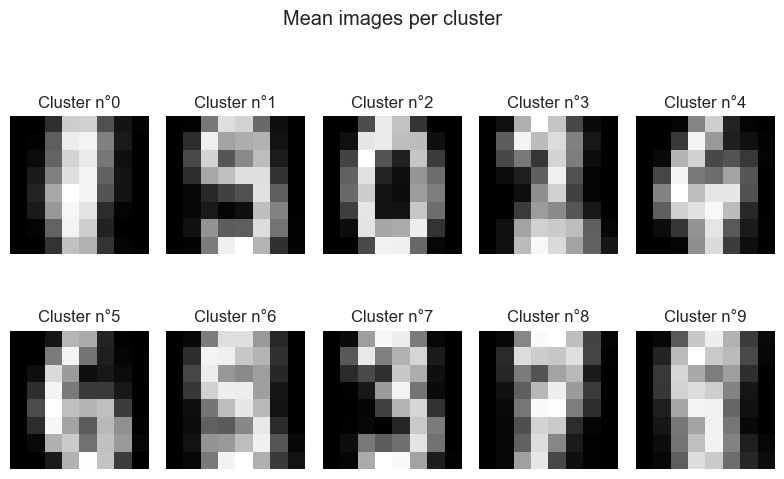

In [18]:
for cluster_id in range(n_digits):
    cluster_indices = np.where(kmean_labels == cluster_id)
    cluster_images = X[cluster_indices]
    mean_image = cluster_images.mean(axis=0).reshape(8, 8)

    plt.subplot(2, 5, cluster_id + 1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(f"Cluster n°{cluster_id}")
    plt.axis('off')

plt.suptitle("Mean images per cluster")
plt.tight_layout()
plt.show()

### Visualization

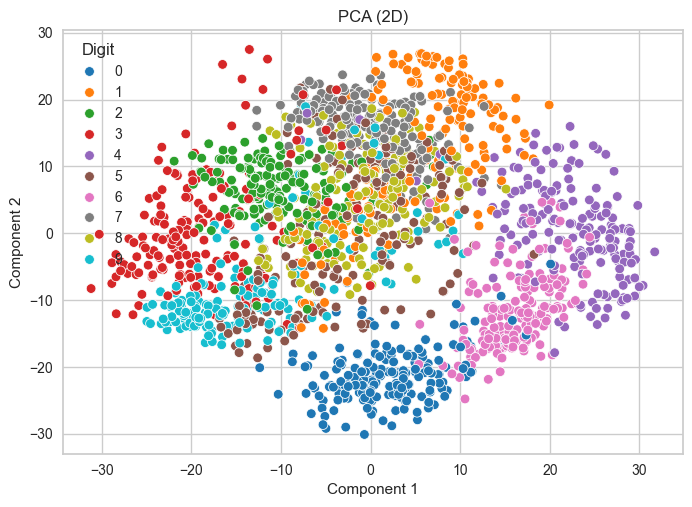

In [19]:
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=data.label, palette='tab10', legend='full')
plt.title("PCA (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Digit")
plt.show()


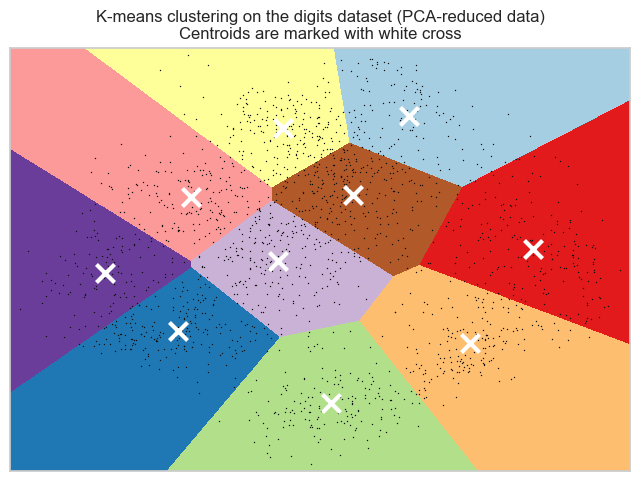

In [20]:


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(());

## Intercluster Distance Maps

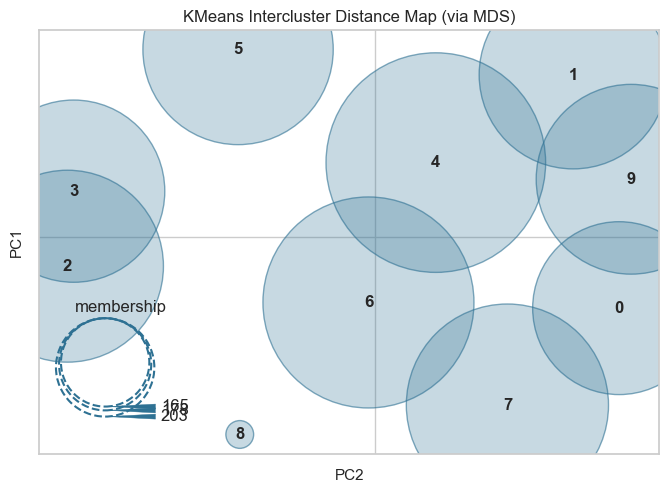

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [21]:
# Instantiate the clustering model and visualizer
model = KMeans(10)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Visualisation with TSNE

In [22]:
# Initialize

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)


Optimiser k-means avec au moins 3 hyperparametres (nombre de clusters, etc)
Tester l'optimisation avec ou sans réduction de dimension (Avec ou sans PCA)
Tester avec ou sans standardisation (Minmax, Standardscaller, Robustscaller)
Faire l'analyse des personnas pour le meilleur modèle
Montrer la visualisation et l'analyse des clusters choisies (Avec t-sne par exemple)
Objet: TPISE-Clustring 2025

# Paramètre à tester

In [23]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import itertools

In [24]:
## nous  optimisons le modèle de clustering K-Means en testant automatiquement plusieurs combinaisons de trois hyperparamètres : 
## le nombre de clusters (entre 8 et 15), le type de standardisation des données (MinMaxScaler, StandardScaler, RobustScaler ou aucune),
## et l’utilisation ou non de la réduction de dimension via l’analyse en composantes principales (PCA)


In [25]:
scalers = {
    "minmax": MinMaxScaler(),
    "standard": StandardScaler(),
    "robust": RobustScaler(),
    "none": None
}

use_pca_options = [True, False]
k_values = range(8, 16)

results = []

for scaler_name, scaler in scalers.items():
    for use_pca in use_pca_options:
        for k in k_values:
            X_temp = X.copy()
            if scaler is not None:
                X_temp = scaler.fit_transform(X_temp)
            if use_pca:
                X_temp = PCA(n_components=0.95).fit_transform(X_temp)
            kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=0)
            labels_pred = kmeans.fit_predict(X_temp)
            score = silhouette_score(X_temp, labels_pred)
            results.append({
                "scaler": scaler_name,
                "use_pca": use_pca,
                "n_clusters": k,
                "silhouette": score
            })

## Sélection du meilleur modèle

In [26]:
results_df = pd.DataFrame(results)
best_config = results_df.sort_values(by="silhouette", ascending=False).iloc[0]
print("Meilleur modèle :", best_config)

Meilleur modèle : scaler            none
use_pca           True
n_clusters           9
silhouette    0.201649
Name: 49, dtype: object


## Relancer le meilleur modèle et attribuer les clusters

In [27]:
best_scaler = scalers[best_config["scaler"]]
X_best = X.copy()

if best_scaler is not None:
    X_best = best_scaler.fit_transform(X_best)

if best_config["use_pca"]:
    X_best = PCA(n_components=0.95).fit_transform(X_best)

kmeans_final = KMeans(n_clusters=int(best_config["n_clusters"]), random_state=0).fit(X_best)
data["cluster"] = kmeans_final.labels_


## Analyse des personnas par clusters

In [28]:
persona_profiles = data.groupby("cluster").mean()
print(persona_profiles)

          X0        X1         X2         X3         X4         X5        X6  \
cluster                                                                        
0        0.0  0.917582  10.104396  14.450549   7.835165   1.054945  0.000000   
1        0.0  0.022222   4.211111  13.127778  11.283333   2.950000  0.033333   
2        0.0  0.000000   1.202186  11.251366   9.568306   1.497268  0.027322   
3        0.0  0.169903   4.956311  12.966019  14.058252  10.873786  4.902913   
4        0.0  0.110619   3.991150  11.889381  12.340708   5.349558  0.429204   
5        0.0  0.000000   0.054348   2.163043  11.206522  12.771739  4.347826   
6        0.0  0.367647   7.500000  13.404412  12.776961   6.220588  0.620098   
7        0.0  0.000000   0.284024   6.952663  11.946746   2.023669  0.147929   
8        0.0  1.092715   9.933775  13.350993  14.139073  12.509934  4.317881   

               X7        X8        X9        X10        X11        X12  \
cluster                                      

In [29]:
pd.crosstab(data["cluster"], data["label"])

label,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,0,25,151,2,0,0,0,0,4,0
1,177,0,1,0,0,0,1,0,1,0
2,0,2,0,0,0,2,177,0,2,0
3,0,0,3,8,8,0,0,175,5,7
4,0,99,8,7,4,0,2,2,102,2
5,0,55,2,0,3,0,1,2,9,20
6,0,0,12,164,0,40,0,0,47,145
7,1,0,0,0,166,2,0,0,0,0
8,0,1,0,2,0,138,0,0,4,6



**Les résultats du clustering révèlent des groupes aux caractéristiques bien distinctes, avec certaines zones de confusion révélatrices. Trois clusters se détachent par leur pureté : le Cluster 1 (98% de "0"), le Cluster 2 (97% de "6") et le Cluster 7 (98% de "4"), formant des archétypes idéaux pour modéliser ces chiffres - suggérant que leurs traits visuels sont parfaitement captés par l'algorithme. À l'inverse, les Clusters 6 et 4 exposent des limites naturelles de la méthode non supervisée : le premier mélange les "3", "8" et "9" , tandis que le second confond les "0", "1" et "8", trahissant soit des similarités géométriques , soit des artefacts d'écriture. Les cas intrigants comme le Cluster 8 (majorité de "5" contaminé par quelques "9") ou le Cluster 0 ("2" dominants pollués par des "1") pourraient s'expliquer par des styles d'écriture ambigus (traits diagonaux ressemblants).**


## Visualisation avec tsne

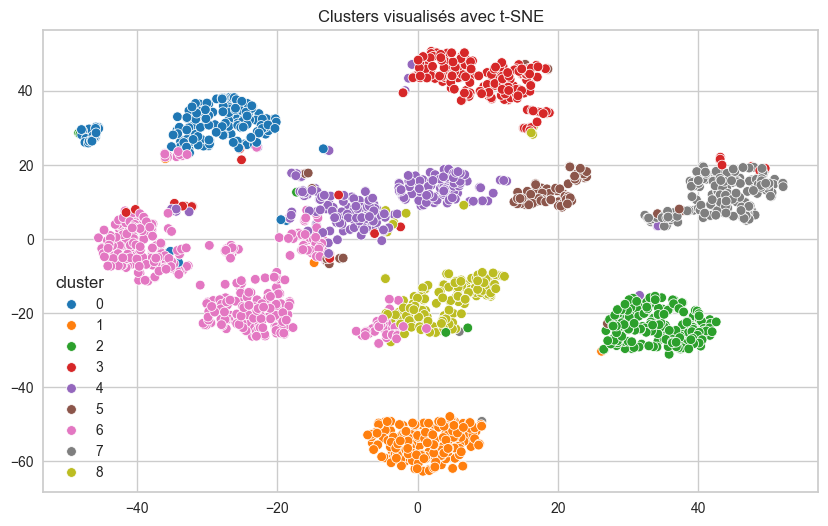

In [30]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_best)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=data["cluster"], palette='tab10')
plt.title("Clusters visualisés avec t-SNE")
plt.show()


**La projection t-SNE révèle une organisation spatiale claire des chiffres, avec plusieurs insights majeurs : les chiffres 0, 1 et 7 forment des clusters bien distincts ,tandis que les chiffres 3, 5 et 8 présentent des chevauchements significatifs . On observe également une proximité ambiguë entre certains 6 et 0 , ainsi qu'une forte variabilité des 2 selon leur style d'écriture. Les 4 et 9 montrent quelques points de contact, probablement causés par des écritures inclinées. Bien que l'algorithme identifie efficacement les formes simples, il peine à distinguer les chiffres à structure complexe. La présence de quelques outliers isolés pourrait indiquer soit des erreurs de labellisation, soit des styles d'écriture atypiques.
Une inspection manuelle des zones de chevauchement permettrait d'identifier précisément les traits ambigus responsables des confusions.**